In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy.signal as signal
from importlib import reload
import lib

In [2]:
class CG:
    def __init__(self, A, b):
        self.A = A
        self.b = b
        self.x = np.zeros_like(b)   
        self.res = np.inf
        self.r = b - self.A(self.x)
        self.d = self.r
        self.norm_b = np.linalg.norm(b)
        
    def step(self):
        a = self.r.T @ self.r / (self.d.T @ self.A(self.d))
        self.x += a * self.d        
        self.res = np.linalg.norm(self.A(self.x) - self.b)/self.norm_b
        r_new = self.r - a * self.A(self.d)
#         self.res = np.sqrt(np.dot(r_new, r_new))
        B = r_new.T @ r_new / (self.r.T @ self.r)
        self.d = r_new + B * self.d
        self.r = r_new

In [3]:
class Mapmaker:
    def __init__(self, nside, baseline_length, verbose=False):
        self.baseline_length = baseline_length
        self.nside = nside
        self.npix = 12*nside**2
        self.verbose = verbose

    def A(self, a):
        return FT(Z(F(a, self.baseline_length, len(self.pixels)), self.pixels, self.npix), self.baseline_length)
    
    def solve(self, obs_list, tol=1e-12, max_iter=100):
        self.tods = np.concatenate([obs.tod for obs in obs_list])
        self.pixels = np.concatenate([obs.pixels for obs in obs_list])
                
        b = FT(Z(self.tods, self.pixels, self.npix), self.baseline_length)
            
        cg = CG(self.A, b)
        for i in range(max_iter):
            if cg.res < tol: break
            cg.step()
            cg.i = i+1
            if self.verbose:
                print(f'Iter {cg.i}, Residual: {cg.res}')
        
        print(f'Residual: {cg.res} in {cg.i} iterations')
        return cg.x

In [4]:
def P(m, pixels):
    return m[pixels]

def PT(y, pixels, npix):
    return np.bincount(pixels, y, minlength=npix)

def PTP(pixels, npix):
    return np.bincount(pixels, minlength=npix)

def Z(y, pixels, npix):
    proj = P(PT(y, pixels, npix)/PTP(pixels, npix), pixels)
    return y - proj

In [5]:
def F(a, baseline_length, nsamp):
    result = [baseline_length*[i] for i in a]
    return np.concatenate(result)[:nsamp]

def FT(y, baseline_length):
    rem = len(y) % baseline_length
    if rem != 0:
        y = np.pad(y, (0, baseline_length - rem))
    return np.sum(y.reshape(-1, baseline_length), axis=1)

In [6]:
def create_pixels():
    #Hardcoded for nside 128, lol
    row_width = 200 #pixels
    offset = 312
    start = 35000
    nrows = 200
    
    pixels_lr = np.array([np.arange(start+i*(offset+row_width), start+row_width+i*(offset+row_width)) for i in range(nrows)])
    pixels_ud = np.copy(pixels_lr.T)
    
    for pixels in (pixels_lr, pixels_ud):
        pixels[::2] = pixels[::2, ::-1] #flip even rows
        
    return np.concatenate(pixels_lr), np.concatenate(pixels_ud)


In [7]:
class Observation:
    def __init__(self, tod, pixels):
        self.tod = tod
        self.pixels = pixels

In [8]:
def bin_map(obs_list, npix):
    noise_weighted_map = np.zeros(npix)
    npp = np.zeros(npix)
    
    for obs in obs_list:
        tod = obs.tod
        pixels = obs.pixels
        noise_weighted_map += PT(tod, pixels, npix)
        npp += PTP(pixels, npix)
    
    return noise_weighted_map / npp

In [9]:
ell, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
cl = np.array([TT, TE, EE, BB])
cl /= ell*(ell+1)/2/np.pi 
for c in cl: c[0] = 0

/tmp/ipykernel_47010/2274385076.py:3: RuntimeWarning: invalid value encountered in true_divide
  cl /= ell*(ell+1)/2/np.pi


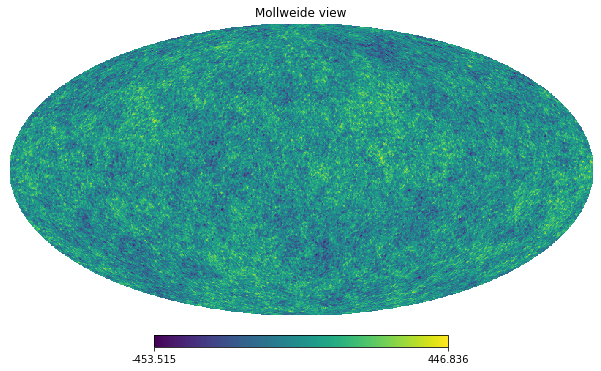

In [10]:
nside = 128
npix = 12*nside**2
lmax = 3*nside-1
sampling_rate = 10 #hz
baseline_length_seconds = 20 #seconds
baseline_length = baseline_length_seconds * sampling_rate
m = hp.synfast(cl[0], nside)

hp.mollview(m)

In [11]:
pixels_lr, pixels_ud = create_pixels()
nsamp = len(pixels_lr)
rate = 10 #hz
times = np.linspace(0, nsamp/rate, nsamp)

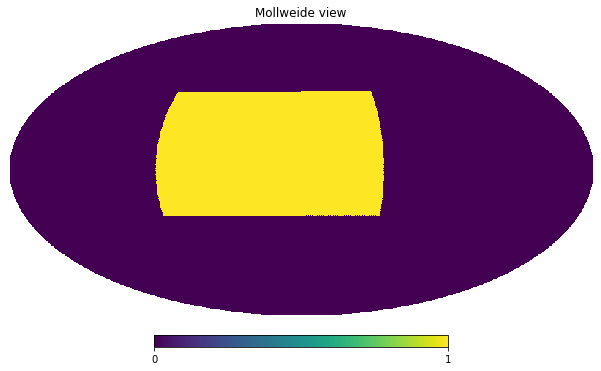

In [12]:
mask = np.zeros(npix)
mask[pixels_lr] = 1
hp.mollview(mask)

In [13]:
signal1 = m[pixels_lr]

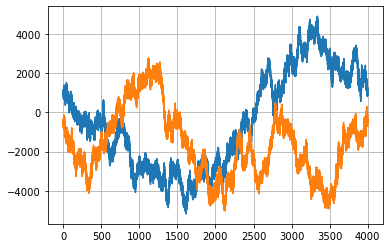

In [14]:
reload(lib)
noise1 = lib.generate_noise(nsamp, 1/sampling_rate, fknee=0.5, alpha=2, sigma=100)
noise2 = lib.generate_noise(nsamp, 1/sampling_rate, fknee=0.5, alpha=2, sigma=100)

plt.plot(times, noise1)
plt.plot(times, noise2)

plt.grid()

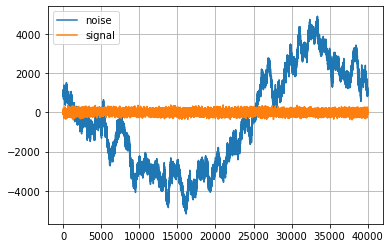

In [15]:
# plt.plot(y, label='signal + noise')
plt.plot(noise1, label='noise')
plt.plot(signal1, label='signal')
plt.legend()
plt.grid()

In [16]:
obs1 = Observation(m[pixels_lr] + noise1, pixels_lr)
obs2 = Observation(m[pixels_ud] + noise2, pixels_ud)

In [17]:
mapmaker = Mapmaker(nside, baseline_length, verbose=True)
a = mapmaker.solve([obs1, obs2], tol=0)

/tmp/ipykernel_47010/297539256.py:11: RuntimeWarning: invalid value encountered in true_divide
  proj = P(PT(y, pixels, npix)/PTP(pixels, npix), pixels)


Iter 1, Residual: 0.3471858565871799
Iter 2, Residual: 1.2810678472835948e-16
Iter 3, Residual: 1.392457754041092e-16
Iter 4, Residual: 1.3926965156604808e-16
Iter 5, Residual: 3.8830318869451743e-16
Iter 6, Residual: 2.135270241568466e-16
Iter 7, Residual: 1.700874667141626e-16
Iter 8, Residual: 1.700874667141626e-16
Iter 9, Residual: 1.700874667141626e-16
Iter 10, Residual: 1.6887111596764816e-16
Iter 11, Residual: 1.6967318748649946e-16
Iter 12, Residual: 1.6967318748649946e-16
Iter 13, Residual: 1.6967318748649946e-16
Iter 14, Residual: 1.6967318748649946e-16
Iter 15, Residual: 1.6967318748649946e-16
Iter 16, Residual: 1.6967318748649946e-16
Iter 17, Residual: 1.6967318748649946e-16
Iter 18, Residual: 1.6967318748649946e-16
Iter 19, Residual: 1.6752028348822884e-16
Iter 20, Residual: 1.674408727349129e-16
Iter 21, Residual: 1.674408727349129e-16
Iter 22, Residual: 1.674408727349129e-16
Iter 23, Residual: 1.674408727349129e-16
Iter 24, Residual: 1.674408727349129e-16
Iter 25, Residu

In [18]:
full_noise = np.concatenate([noise1, noise2])
baselines = F(a, baseline_length, len(full_noise))

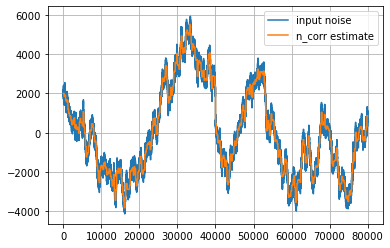

In [19]:
plt.plot(full_noise-np.mean(full_noise), label='input noise')
plt.plot(baselines- np.mean(baselines) , label='n_corr estimate')
plt.grid()
plt.legend()

In [20]:
#Subtract noise
obs1.tod -= baselines[:nsamp]
obs2.tod -= baselines[nsamp:]

In [21]:
m_destripe = bin_map([obs1, obs2], npix) #Destriping solution

#remove monopole
m_destripe -= np.nanmean(m_destripe)

/tmp/ipykernel_47010/3971746450.py:11: RuntimeWarning: invalid value encountered in true_divide
  return noise_weighted_map / npp


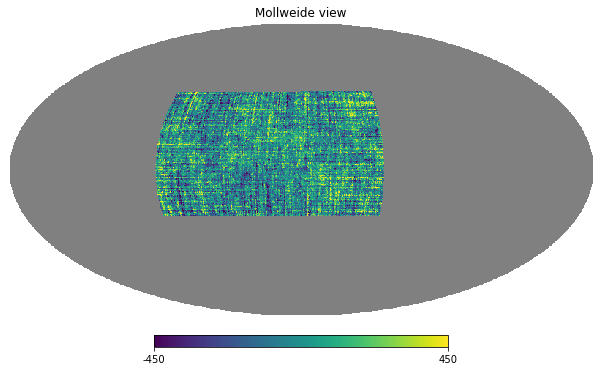

In [22]:
hp.mollview(m_destripe, min=-450, max=450)

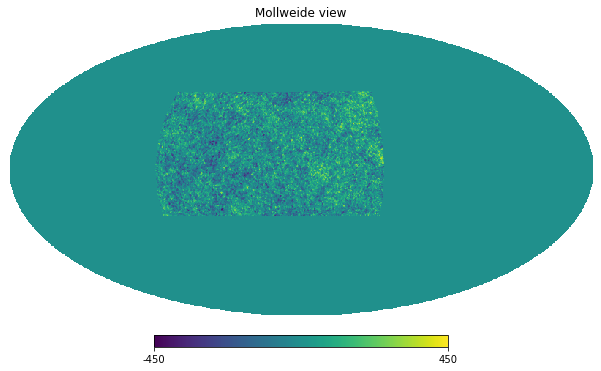

In [23]:
hp.mollview(mask*m, min=-450, max=450)

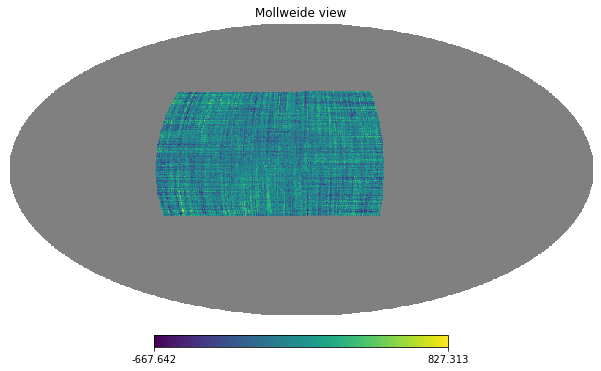

In [24]:
hp.mollview(m-m_destripe)